# Notebook for checking basic `pyforce` functionalities
This notebook is not meant to be a tutorial, but a full execution (offline and online) of the basic functionalities of `pyforce` starting from a toy dataset from a Poisson problem, either in 1D or 2D.
In particular, the following methods are tested:

- Proper Orthogonal Decomposition using Correlation Matrix + projection and interpolation in the online phase
- Generalised Empirical Interpolation methods
- SGREEDY algorithm for sensor selection
- Parameterised-Background Data-Weak formulation

## Toy Dataset
Let $u(\mathbf{x}, \boldsymbol{\mu})$ be the solution of the following Poisson Problem in $ \mathbf{x}\in\Omega = [0, 1]^n$, given $n={1,2}$

\begin{equation*}
- k \cdot\Delta u = q(\mathbf{x}, \boldsymbol{\mu}) = \sin(\mu_1 \cdot  \pi \cdot x)\cdot e^{-\frac{||\mathbf{x}||^2}{\mu_2}}
\end{equation*}
with $k = 0.2$. Either in 1D or 2D, homogeneous Dirichlet conditions are imposed at the boundary.
The parameters $\boldsymbol{\mu}\in\mathcal{D}\subset\mathbb{R}^2$ is given by
\begin{equation*}
\mu_1 \in [1, 3] \qquad \qquad \mu_2 \in [0.2, 0.5]
\end{equation*}

Let us define the dataset, by generating the domain and the snapshots.

In [1]:
from toy_data import *

domain, V = toy_domain(Nh = 20, gdim = 2)
params, snaps = toy_dataset(domain, V, Ns = [25, 25])

Creating Dataset: 625.000 / 625.00 - 0.004 s/it


Let us split it into train and test, randomly

In [2]:
from pyforce.tools.functions_list import train_test_split

mu_train, mu_test, train_snaps, test_snaps = train_test_split(params, snaps)

Let us define the structures to save the errors, the coefficients, the basis functions and sensors, and the online computation costs.

In [3]:
offline_errors = dict()
online_errors  = dict()

offline_coefficients = dict()

basis_functions = dict()
basis_sensors   = dict()

online_comput_costs = dict()

## Offline Phase
In this section, the reduced basis are generated along with the sensors.

### Proper Orthogonal Decomposition
The reduction via POD is performed, the correlation matrix formulation is used.

In [4]:
from pyforce.offline.pod import POD

pod_offline = POD(train_snaps, name='u', use_scipy=True, verbose=True)

Computing u correlation matrix: 418.000 / 418.00 - 0.034 s/it


Let us plot the eigenvalues of the correlation matrix

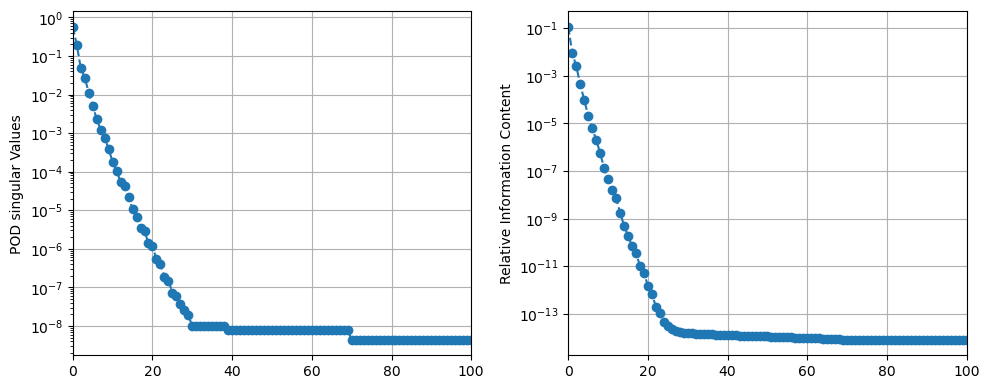

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

axs[0].semilogy(np.sqrt(pod_offline.eigenvalues), '--o')
axs[0].set_xlim(0,100)
axs[0].grid()
axs[0].set_ylabel('POD singular Values')

axs[1].semilogy(1-np.cumsum(pod_offline.eigenvalues) / np.sum(pod_offline.eigenvalues), '--o')
axs[1].set_xlim(0,100)
axs[1].grid()
axs[1].set_ylabel('Relative Information Content')

plt.tight_layout()

Let us compute the basis functions and the training error for the POD

In [6]:
maxBasis = 40

pod_offline.compute_basis(train_snaps, maxBasis=maxBasis, normalise=True)
basis_functions['POD'] = pod_offline.PODmodes

offline_errors['POD'] = dict()
offline_errors['POD']['abs'], offline_errors['POD']['rel'], offline_coefficients['POD'] = pod_offline.train_error(train_snaps, maxBasis=maxBasis, verbose=True)

Computing train error u: 418.000 / 418.00 - 0.026 s/it


### Generalised Empirical Interpolation Method
This algorithm is used to generate a set of magic functions and sensors

In [7]:
from pyforce.offline.geim import GEIM

offline_errors['GEIM'] = dict()

geim_offline = GEIM(domain, V, 'u', s=0.01)
offline_errors['GEIM']['abs'], offline_errors['GEIM']['rel'], offline_coefficients['GEIM'] = geim_offline.offline(train_snaps, maxBasis, sampleEvery = 1, verbose = True)

basis_functions['GEIM'] = geim_offline.magic_fun
basis_sensors['GEIM'] = geim_offline.magic_sens

Generating sensors (sampled every 1 cells): 441.000 / 441.00 - 0.004 s/it


### SGREEDY for sensor placement
This algorithm starts from the POD basis and hierarchically select the sensors in the domain

In [8]:
from pyforce.offline.sensors import SGREEDY

is_H1 = True

sgreedy = SGREEDY(domain, basis_functions['POD'], V, 'u', s=0.01)
sgreedy.generate(10, maxBasis, sampleEvery=1, is_H1=is_H1, verbose=True)
basis_sensors['SGREEDY'] = sgreedy.basis_sens

Generating sensors (sampled every 1 cells): 441.000 / 441.00 - 0.005 s/it
  = 11, n = 10 | beta_n,m = 0.229878
-----------------------------------------
Starting approximation loop
 
m = 40, n = 10 | beta_n,m = 0.512819


### Plotting offline results
The training error is plotted in terms of maximum absolute and relative error.

Text(0, 0.5, '$\\varepsilon_N$')

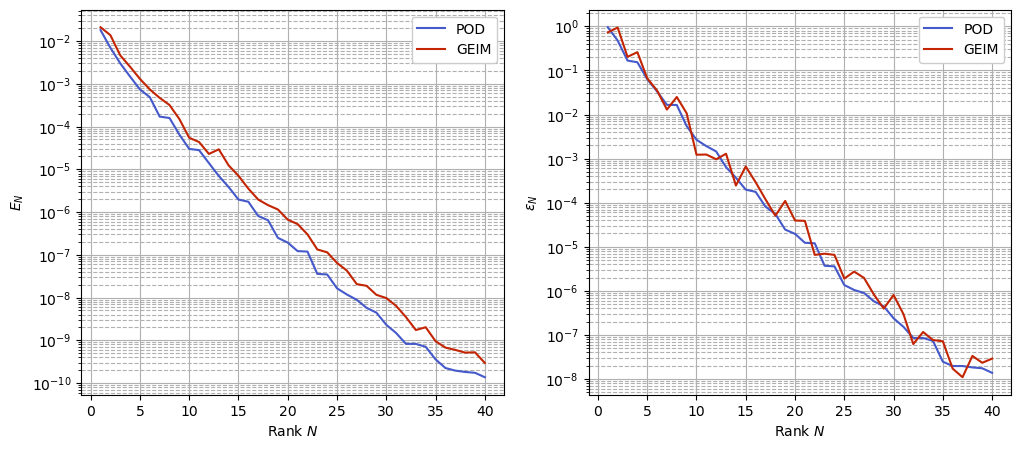

In [9]:
from matplotlib import cm

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

algos = list(offline_errors.keys())
colors = cm.turbo(np.linspace(0.1,0.9,len(algos)))

N_to_plot = np.arange(1, maxBasis+1, 1)

for algo_i in range(len(algos)):
    axs[0].semilogy(N_to_plot, offline_errors[algos[algo_i]]['abs'], c=colors[algo_i], label=algos[algo_i])
    axs[1].semilogy(N_to_plot, offline_errors[algos[algo_i]]['rel'], c=colors[algo_i], label=algos[algo_i])
    
for ax in axs:
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.set_xlabel('Rank $N$')
    ax.set_xticks(np.arange(0, maxBasis+1, 5))
    ax.legend(framealpha=1)
axs[0].set_ylabel(r'$E_N$')
axs[1].set_ylabel(r'$\varepsilon_N$')

## Online Phase
In this section, the POD (project and interpolation), the GEIM and the PBDW are going to be tested on unseen parameters.

In [10]:
N_max = 25

### POD with Projection
The reduced coefficients are obtained by projecting the snapshots onto the reduced space
\begin{equation*}
\alpha_n(\boldsymbol{\mu}) = \int_\Omega u(\mathbf{x};\boldsymbol{\mu})\cdot \psi_n(\mathbf{x})\,d\mathbf{x}
\end{equation*}

In [11]:
from pyforce.online.pod_projection import PODproject

pod_proj_online = PODproject(basis_functions['POD'], 'u')

online_errors['POD'] = dict()
online_errors['POD']['abs'], online_errors['POD']['rel'], online_comput_costs['POD'] = pod_proj_online.synt_test_error(test_snaps, N_max, verbose=True)

Computing POD test error (projection) - u: 207.000 / 207.00 - 0.011 s/it


### POD with Interpolation
The reduced coefficients are estimated using interpolation/regression methods, starting from the training ones
\begin{equation*}
\mathcal{F}_n:\boldsymbol{\mu}\longrightarrow \alpha_n(\boldsymbol{\mu})
\end{equation*}

In [12]:
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

map_interp = [NearestNDInterpolator(mu_train, offline_coefficients['POD'][:,nn]) for nn in range(maxBasis)]
# map_interp = [LinearNDInterpolator(mu_train, offline_coefficients['POD'][:,nn], fill_value=0) for nn in range(maxBasis)]

Once these maps are known, we can estimate the unseen parameters using POD-I

In [13]:
from pyforce.online.pod_interpolation import PODI

pod_interp_online = PODI(basis_functions['POD'], map_interp, 'u')

online_errors['PODI'] = dict()
online_errors['PODI']['abs'], online_errors['PODI']['rel'], online_comput_costs['PODI'] = pod_interp_online.synt_test_error(test_snaps, mu_test, N_max, verbose=True)

Computing POD test error (interpolation) - u: 207.000 / 207.00 - 0.013 s/it


### Generalised Empirical Interpolation Method
The sensors and the magic functions are used to estimate the online coefficients

In [14]:
from pyforce.online.geim import GEIM

geim_online = GEIM(basis_functions['GEIM'], basis_sensors['GEIM'], 'u')

online_errors['GEIM'] = dict()
online_errors['GEIM']['abs'], online_errors['GEIM']['rel'], online_comput_costs['GEIM'] = geim_online.synt_test_error(test_snaps, N_max, verbose=True)

Computing GEIM test error (synthetic) - u: 207.000 / 207.00 - 0.015 s/it


### Parameterised-Background Data-Weak formulation
The SGREEDY sensors and the POD modes are used to estimate the online coefficients

In [15]:
from pyforce.online.pbdw_synthetic import PBDW

pbdw_online = PBDW(basis_functions['POD'], basis_sensors['SGREEDY'], 'u', is_H1 = is_H1)

online_errors['PBDW'] = dict()
online_errors['PBDW']['abs'], online_errors['PBDW']['rel'], online_comput_costs['PBDW'] = pbdw_online.synt_test_error(test_snaps, 10, N_max, verbose = True)

Computing PBDW test error (synthetic) with N = 10 - u: 207.000 / 207.00 - 0.014 s/it


### Plotting online errors and computational costs
The average absolute and relative errors on the test snapshots is plotted for each algorithm.

Text(0, 0.5, '$\\varepsilon_N$')

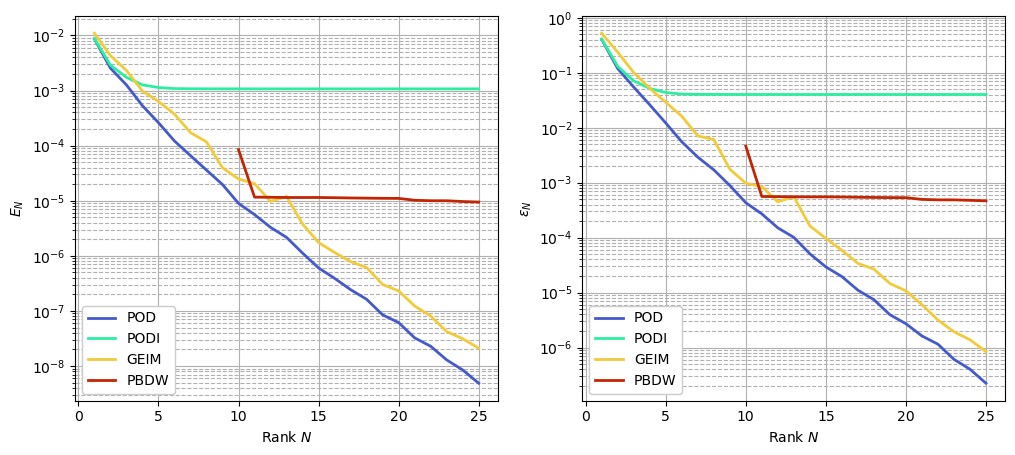

In [16]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

algos = list(online_errors.keys())
colors = cm.turbo(np.linspace(0.1,0.9,len(algos)))

N_to_plot = np.arange(1, N_max+1, 1)

for algo_i in range(len(algos)):
    
    if algos[algo_i] == 'PBDW':
        axs[0].semilogy(N_to_plot[9:], online_errors[algos[algo_i]]['abs'], c=colors[algo_i], label=algos[algo_i], linewidth = 2)
        axs[1].semilogy(N_to_plot[9:], online_errors[algos[algo_i]]['rel'], c=colors[algo_i], label=algos[algo_i], linewidth = 2)
    else:    
        axs[0].semilogy(N_to_plot, online_errors[algos[algo_i]]['abs'], c=colors[algo_i], label=algos[algo_i], linewidth = 2)
        axs[1].semilogy(N_to_plot, online_errors[algos[algo_i]]['rel'], c=colors[algo_i], label=algos[algo_i], linewidth = 2)

for ax in axs:
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.set_xlabel('Rank $N$')
    ax.set_xticks(np.arange(0, N_max+1, 5))
    ax.legend(framealpha=1)
axs[0].set_ylabel(r'$E_N$')
axs[1].set_ylabel(r'$\varepsilon_N$')

Let us now plot the computational costs (the time given by the POD/PODI is specific to a single coefficient)

Text(0, 0.5, 'CPU time to estimate 10 coefficients (s)')

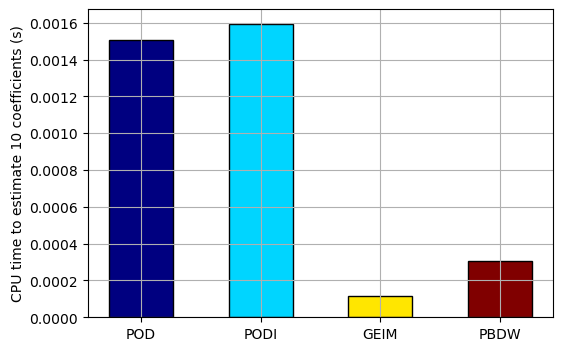

In [17]:
fig, axs = plt.subplots(figsize=(6,4))

algos = list(online_comput_costs.keys())

N_estimation = 10

width = 1.5
_algo = np.arange(0, width * len(algos), width)
ave_online_cost = [
    np.mean(online_comput_costs['POD']['CoeffEstimation'].mean(axis=0)) * N_estimation,
    np.mean(online_comput_costs['PODI']['CoeffEstimation'].mean(axis=0)) * N_estimation,
    online_comput_costs['GEIM']['LinearSystem'].mean(axis=0)[N_estimation-1],
    online_comput_costs['PBDW']['LinearSystem'].mean(axis=0)[N_estimation-10]
]

axs.bar(_algo, ave_online_cost, color=cm.jet(np.linspace(0,1,len(algos))), edgecolor='k')
axs.set_xticks(_algo, algos)
axs.grid()
axs.set_ylabel('CPU time to estimate '+str(N_estimation)+' coefficients (s)')

### Plotting the reconstruction
The algorithms are used to estimate the full-order solution

In [18]:
N_to_use = 10
mu_to_recon = 70

reconstructions = dict()
residuals = dict()

# POD - Project
reconstructions['POD'], residuals['POD'], _ = pod_proj_online.reconstruct(test_snaps(mu_to_recon), N_to_use)

# POD - Interpolation
reconstructions['PODI'], residuals['PODI'], _ = pod_interp_online.reconstruct(test_snaps(mu_to_recon), mu_test[mu_to_recon].reshape(-1,2), N_to_use)

# GEIM
reconstructions['GEIM'], residuals['GEIM'], _ = geim_online.reconstruct(test_snaps(mu_to_recon), N_to_use)

# PBDW
reconstructions['PBDW'], residuals['PBDW'], _ = pbdw_online.reconstruct(test_snaps(mu_to_recon), 10, N_to_use)

Let us make some contour plots using `matplotlib`

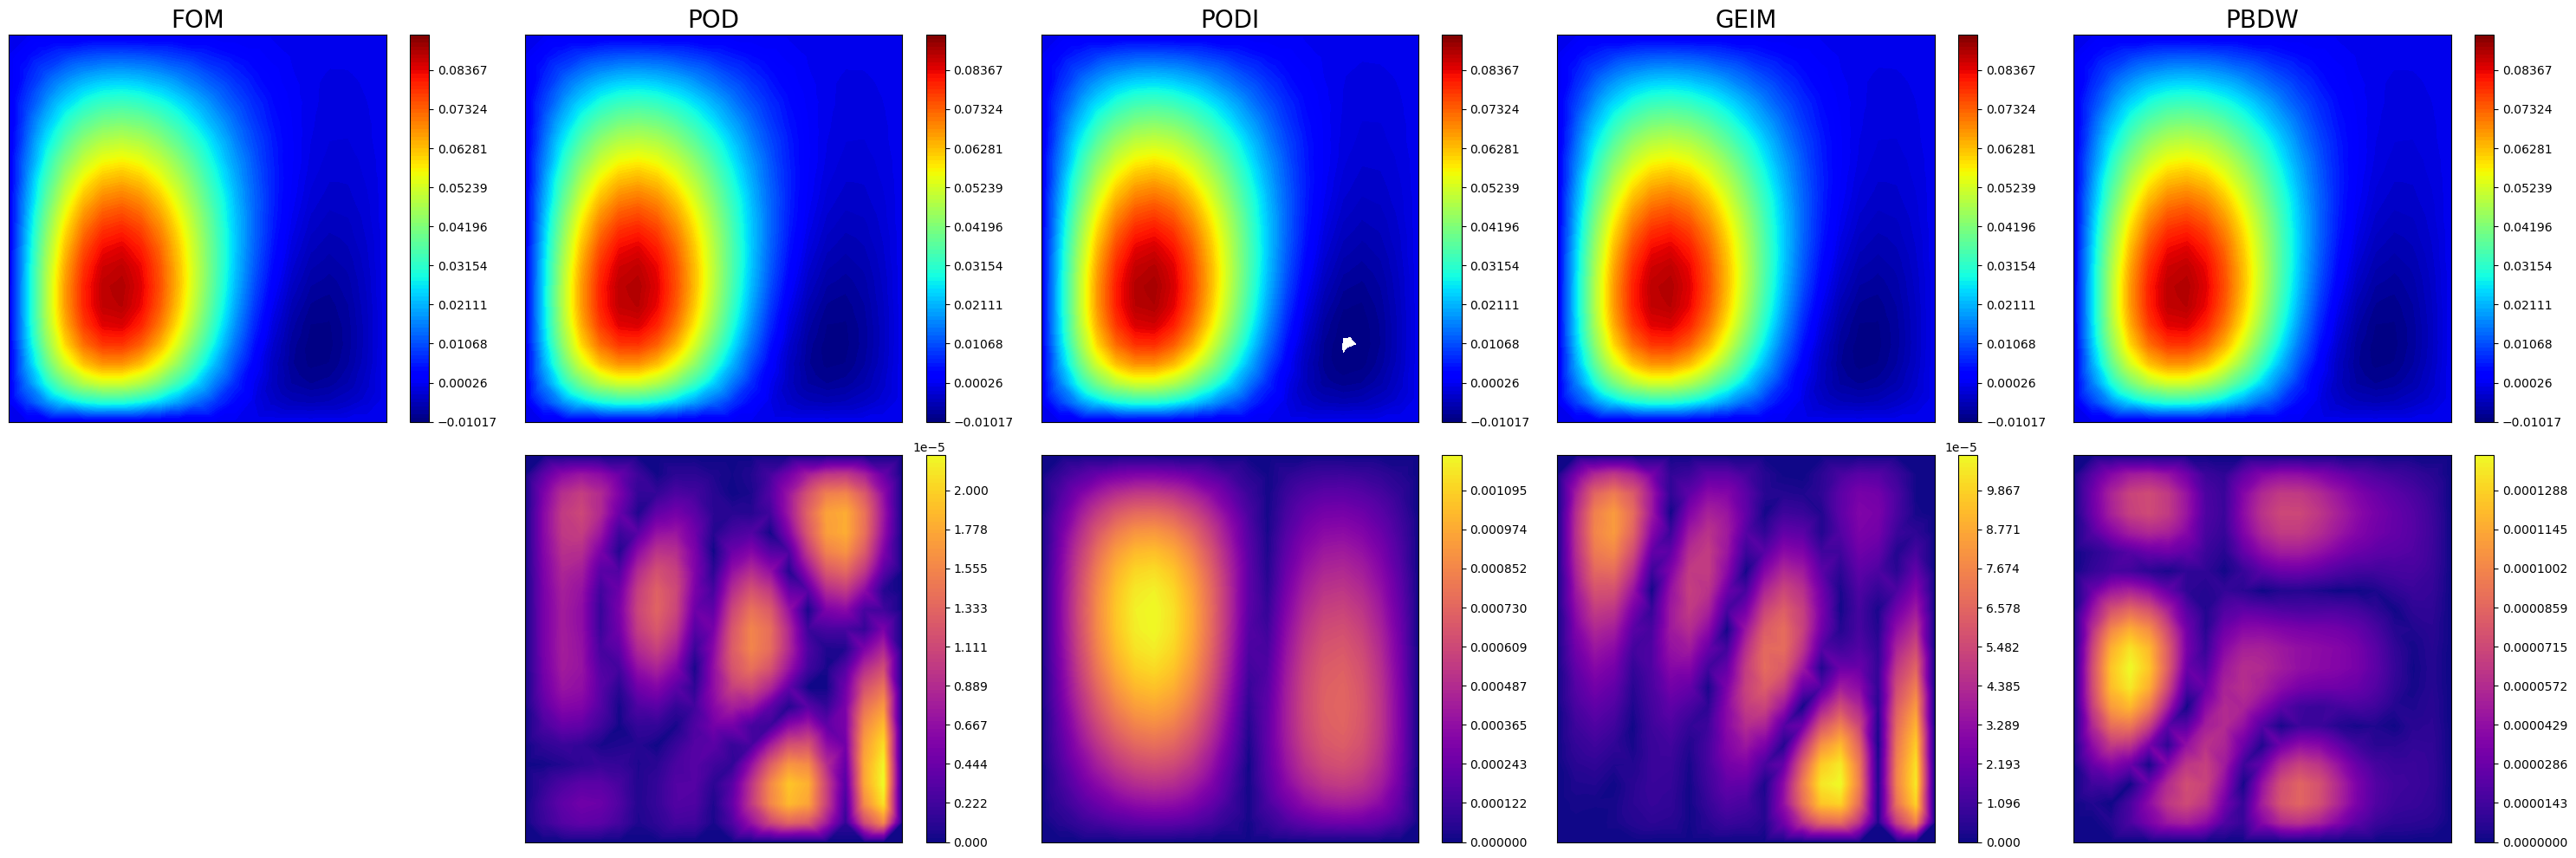

In [19]:
mesh = domain.geometry.x

algos = list(reconstructions.keys())
assert len(algos) == len(residuals.keys())

ncols = len(algos)+1
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))

cmin = min(test_snaps(mu_to_recon)) * 1.05
cmax = max(test_snaps(mu_to_recon)) * 1.05

# FOM plot
plot1 = axs[0, 0].tricontourf(mesh[:,0], mesh[:,1], test_snaps(mu_to_recon), levels = np.linspace(cmin, cmax, 100), cmap=cm.jet, vmin=cmin, vmax=cmax)
plt.colorbar(plot1)
axs[0, 0].set_title('FOM', fontsize=20)

# Reconstructions
rec_plots = dict()
for algo_i in range(len(algos)):
    rec_plots[algos[algo_i]] = axs[0, 1+algo_i].tricontourf(mesh[:,0], mesh[:,1], reconstructions[algos[algo_i]], levels = np.linspace(cmin, cmax, 100), cmap=cm.jet, vmin=cmin, vmax=cmax)
    plt.colorbar(rec_plots[algos[algo_i]])
    axs[0, 1+algo_i].set_title(algos[algo_i], fontsize=20)
    
# Residuals
res_plots = dict()
for algo_i in range(len(algos)):
    res_plots[algos[algo_i]] = axs[1, 1+algo_i].tricontourf(mesh[:,0], mesh[:,1], residuals[algos[algo_i]], 
                                                            levels = np.linspace(min(residuals[algos[algo_i]]), max(residuals[algos[algo_i]]), 100), cmap=cm.plasma)
    plt.colorbar(res_plots[algos[algo_i]])
    
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
axs[1,0].axis('off')
plt.tight_layout()